<a href="https://colab.research.google.com/github/RaoSiddhant/SIT796_RL/blob/main/Task_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
#FOR VALUE ITERATION
#Importing Relevant Packages for the Environment Setup
#This is th same environment we set up for Task 1.1 and 1.2
#We have a university campus map, states, actions taken by bus defined here
#and we use this later to show Value Iteration on this scoped environment 
import sys
from contextlib import closing
from io import StringIO
from gym import utils
from gym.envs.toy_text import discrete
import numpy as np
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np

CAMPUS_MAP = [
    "+---------+",
    "|R: | : :G|",
    "| : | : : |",
    "| : : : : |",
    "| | : | : |",
    "|Y| : |B: |",
    "+---------+",
]

class Univ_Camp_Bus(discrete.DiscreteEnv):
    
    def __init__(self):
        self.desc = np.asarray(CAMPUS_MAP, dtype='c')

        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3)]

        num_states = 500
        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        P = {state: {action: []
                     for action in range(num_actions)} for state in range(num_states)}
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside bus
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1  # default reward when there is no pickup/dropoff
                            done = False
                            bus_loc = (row, col)

                            if action == 0:
                                new_row = min(row + 1, max_row)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                new_col = min(col + 1, max_col)
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if (pass_idx < 4 and bus_loc == locs[pass_idx]):
                                    new_pass_idx = 4
                                else:  # batch of students not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (bus_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 20
                                elif (bus_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(bus_loc)
                                else:  # dropoff at wrong location
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx)
                            P[state][action].append(
                                (1.0, new_state, reward, done))
        initial_state_distrib /= initial_state_distrib.sum()
        discrete.DiscreteEnv.__init__(
            self, num_states, num_actions, P, initial_state_distrib)

    def encode(self, bus_row, bus_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = bus_row
        i *= 5
        i += bus_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

    def np_random(seed=None):
      if seed is not None and not (isinstance(seed, int) and 0 <= seed):
        raise error.Error('Seed must be a non-negative integer or omitted, not {}'.format(seed))

      seed = create_seed(seed)

      rng = np.random.RandomState()
      rng.seed(_int_list_from_bigint(hash_seed(seed)))
      return rng, seed

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        bus_row, bus_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x): return "_" if x == " " else x
        if pass_idx < 4:
            out[1 + bus_row][2 * bus_col + 1] = utils.colorize(
                out[1 + bus_row][2 * bus_col + 1], 'yellow', highlight=True)
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
        else:  # Batch of students in bus
            out[1 + bus_row][2 * bus_col + 1] = utils.colorize(
                ul(out[1 + bus_row][2 * bus_col + 1]), 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], 'magenta')
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["South", "North", "East", "West", "Pickup", "Dropoff"][self.lastaction]))
        else:
            outfile.write("\n")

        # No need to return anything for human
        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()


  


In [42]:
#VALUE ITERATION FOR MDP's For our evironment as per task 1.1 and 1.2 
#Importing Relevant Packages 

import gym # openAi gym
from gym import envs
import numpy as np 
import datetime
import keras 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd 
from time import sleep
import warnings
warnings.filterwarnings('ignore')


#Calling the environment and showing the numer of States, Actions and Transition Probabilities, nexte state and rewards for each State-Action Pair
env = Univ_Camp_Bus()
env.reset()

print('Number of States for our Environment are:',env.observation_space.n)
print('Number of Actions for our Environment are:',env.action_space.n)

Number of States for our Environment are: 500
Number of Actions for our Environment are: 6


In [43]:
#We define the VALUE ITERATION function here
#It takes the environment which we defined above, theta or the the limit to stop evaluation if value reaches below this value
#and discount factor gamma here
#It returns a tuple of the optimal policy and the optimal value function

def value_iteration(env, theta, discount_factor):

    
    def one_step_lookahead(state, V):
        
        A = np.zeros(env.nA)
        for act in range(env.nA):
            for prob, next_state, reward, done in env.P[state][act]:
                A[act] += prob * (reward + discount_factor*V[next_state])
        return A
    
    V = np.zeros(env.nS)
    while True:
        delta = 0  #checker for improvements across states
        for state in range(env.nS):
            act_values = one_step_lookahead(state,V)  #lookahead one step
            best_act_value = np.max(act_values) #get best action value
            delta = max(delta,np.abs(best_act_value - V[state]))  #find max delta across all states
            V[state] = best_act_value  #update value to best action value
        if delta < theta:  #if max improvement less than threshold
            break
    policy = np.zeros([env.nS, env.nA])
    for state in range(env.nS):  #for all states, create deterministic policy
        act_val = one_step_lookahead(state,V)
        best_action = np.argmax(act_val)
        policy[state][best_action] = 1
        
    
    # Implement!
    return policy, V

In [44]:
env = Univ_Camp_Bus()
val_iter_policy = value_iteration(env,theta=0.00001,discount_factor=0.99)
print('The optimal policy chosen as per value iteration is:\n',val_iter_policy[0])

The optimal policy chosen as per value iteration is:
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


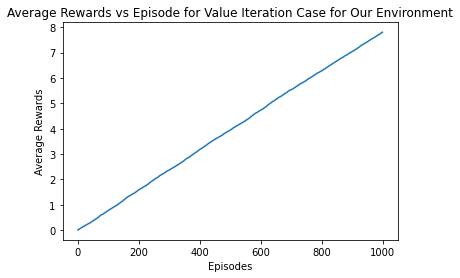

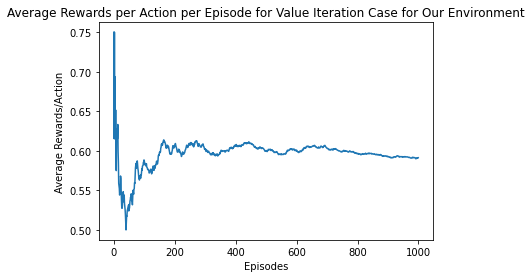

The Total Rewards for all 1000 episodes are:  7803
The Average Rewards for all 1000 episodes are:  7.803


In [45]:
#We finally show the Average Rewards vs Episodes for Value Iteration
def play_episodes(environment, n_episodes, policy):
        count = 0
        total_reward = 0
        avg_rew=[]
        rew_per_cnt=[]
        for episode in range(n_episodes):
          terminated = False
          state = environment.reset()
          while not terminated:
            # Select best action to perform in a current state
            action = np.argmax(policy[state])
            # Perform an action an observe how environment acted in response
            next_state, reward, terminated, info = environment.step(action)
            # Summarize total reward
            count+=1
            
            total_reward += reward
            reward_per_count = total_reward/count
                                                
            # Update current state
            state = next_state
          
          avg_rew.append(total_reward/n_episodes) 
          rew_per_cnt.append(reward_per_count)          
                        
        average_reward = total_reward / n_episodes
        plt.plot(avg_rew)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        plt.title('Average Rewards vs Episode for Value Iteration Case for Our Environment')
        plt.show()
        plt.plot(rew_per_cnt)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards/Action')
        plt.title('Average Rewards per Action per Episode for Value Iteration Case for Our Environment')
        plt.show()
        return total_reward, average_reward

# Number of episodes. We keep it to 1000 as per the question
n_episodes = 1000

# Call the chosen environment
environment = Univ_Camp_Bus()
# Search for an optimal policy using value iteration
policy = val_iter_policy[0]
# Apply best policy to the real environment
total_reward, average_reward = play_episodes(environment, n_episodes, policy)
print('The Total Rewards for all 1000 episodes are: ',total_reward)
print('The Average Rewards for all 1000 episodes are: ',average_reward)